In [2]:
import pandas as pd
import os
import geopandas as gpd
import geojson
import networkx as nx
import csv
import numpy as np
import os
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from datetime import datetime

/home/sara/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_5783/1278731834.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (c

In [3]:
disp_data = pd.read_excel(r'/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx')

In [4]:
v= disp_data["Month End"]
v=v.values
dt = [datetime.strptime(v[i], "%d/%m/%Y") for i in range(len(v))]
q=[]
for i in range(len(dt)):
    q.append(datetime.timestamp(dt[i])) 
disp_data.insert(loc=3, column='date_timestamp', value=q)
disp_data = disp_data.sort_values("date_timestamp")
disp_data['Month End'] = pd.to_datetime(disp_data['Month End'], dayfirst=True)

aggregated_data = disp_data.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) District', 'Current (Arrival) District']).agg({'Number of Individuals':'sum', 'Reason':'first'})
dates = aggregated_data.index.get_level_values('Month End').unique()
districts = aggregated_data.index.get_level_values('Previous (Departure) District').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) District','Current (Arrival) District'])
disp_data1 = aggregated_data.reindex(all_combinations, fill_value=0).reset_index() 

disp_matxs = disp_data1.pivot_table(index=['time','Previous (Departure) District'], columns='Current (Arrival) District', values='Number of Individuals', aggfunc='sum')
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

## Plot sum in degree

In [44]:
# initialize empty lists to store the degree and self weight arrays
df_national_list = []
df_stats_list = []

# loop over the files in the directory
for f, time in tqdm(enumerate(disp_data1['time'].unique())):
 
    df = disp_data1[disp_data1['time']==time]

    G = nx.from_pandas_edgelist(df, source='Previous (Departure) District', target='Current (Arrival) District', 
                    edge_attr=['Number of Individuals'], create_using=nx.MultiDiGraph())

    nodes = list(nx.nodes(G))
    in_degrees_dict=dict(G.in_degree(weight='Number of Individuals'))
    in_degrees = list(in_degrees_dict.values())
    out_degrees_dict=dict(G.out_degree(weight='Number of Individuals'))
    out_degrees = list(out_degrees_dict.values())
    OD = nx.adjacency_matrix(G, weight='Number of Individuals')
    OD_arr = OD.toarray()
    nan_one=np.empty(1)
    nan_one[:]=np.nan
    self_weight = [np.divide(OD_arr[i, i], np.sum(OD_arr[i]), out=nan_one, where=not(np.isnan(np.sum(OD_arr[i])) or np.sum(OD_arr[i])==0))[0] for i in range(len(OD_arr))]

    # calculate the mean and quantiles of the degree and self weight arrays
    mean_degree = np.nanmean(in_degrees)
    in_degree_quantiles = np.nanquantile(in_degrees, [0.025, 0.5, 0.975])
    out_degree_quantiles = np.nanquantile(out_degrees, [0.025, 0.5, 0.975])

    mean_self_weight = np.nanmean(self_weight)
    self_weight_quantiles = np.nanquantile(self_weight, [0.025, 0.5, 0.975])
    
    # append the degree and self weight arrays and their quantiles to the lists
    date_list=[time]*len(nodes)
    df_national=pd.DataFrame({'date':time, 'mean_degree': mean_degree, 'mean_self_weight': mean_self_weight, 'in_degree_lower': in_degree_quantiles[0], 'in_degree_median': in_degree_quantiles[1], 'in_degree_upper': in_degree_quantiles[2], 'out_degree_lower': out_degree_quantiles[0], 'out_degree_median': out_degree_quantiles[1], 'out_degree_upper': out_degree_quantiles[2], 'self_weight_lower': self_weight_quantiles[0],'self_weight_median': self_weight_quantiles[1],'self_weight_upper': self_weight_quantiles[2]}, index=[0])
    df_national_list.append(df_national)
    df_stats = pd.DataFrame({'date':date_list,'geoid': nodes, 'sum_in_degree': in_degrees, 'out_degree': out_degrees,'self_weight': self_weight})
    df_stats_list.append(df_stats)

    df_stats = pd.concat(df_stats_list)
#df_stats['date'] = df_stats['date'].str.replace('_', '-')
df_stats['date'] = pd.to_datetime(df_stats['date'])
df_national = df_stats.groupby('date').agg({'sum_in_degree': 'sum', 'out_degree': 'mean', 'self_weight': 'mean'})
df_national = df_national.reset_index()

#cut df_national until 2022-12-31
df_national_all = df_national[df_national['date'] <= '2022-12-31']

0it [00:00, ?it/s]

92it [00:05, 16.88it/s]


In [45]:
# initialize empty lists to store the degree and self weight arrays
df_national_list = []
df_stats_list = []

disp_data2=disp_data1.copy()
disp_data2['Number of Individuals'] = np.where(disp_data2['Reason']!='Conflict/Insecurity', 0, disp_data2['Number of Individuals'])

# loop over the files in the directory
for f, time in tqdm(enumerate(disp_data2['time'].unique())):
 
    df = disp_data2[disp_data2['time']==time]

    G = nx.from_pandas_edgelist(df, source='Previous (Departure) District', target='Current (Arrival) District', 
                    edge_attr=['Number of Individuals'], create_using=nx.MultiDiGraph())

    nodes = list(nx.nodes(G))
    in_degrees_dict=dict(G.in_degree(weight='Number of Individuals'))
    in_degrees = list(in_degrees_dict.values())
    out_degrees_dict=dict(G.out_degree(weight='Number of Individuals'))
    out_degrees = list(out_degrees_dict.values())
    OD = nx.adjacency_matrix(G, weight='Number of Individuals')
    OD_arr = OD.toarray()
    nan_one=np.empty(1)
    nan_one[:]=np.nan
    self_weight = [np.divide(OD_arr[i, i], np.sum(OD_arr[i]), out=nan_one, where=not(np.isnan(np.sum(OD_arr[i])) or np.sum(OD_arr[i])==0))[0] for i in range(len(OD_arr))]

    # calculate the mean and quantiles of the degree and self weight arrays
    mean_degree = np.nanmean(in_degrees)
    in_degree_quantiles = np.nanquantile(in_degrees, [0.025, 0.5, 0.975])
    out_degree_quantiles = np.nanquantile(out_degrees, [0.025, 0.5, 0.975])

    mean_self_weight = np.nanmean(self_weight)
    self_weight_quantiles = np.nanquantile(self_weight, [0.025, 0.5, 0.975])
    
    # append the degree and self weight arrays and their quantiles to the lists
    date_list=[time]*len(nodes)
    df_national=pd.DataFrame({'date':time, 'mean_degree': mean_degree, 'mean_self_weight': mean_self_weight, 'in_degree_lower': in_degree_quantiles[0], 'in_degree_median': in_degree_quantiles[1], 'in_degree_upper': in_degree_quantiles[2], 'out_degree_lower': out_degree_quantiles[0], 'out_degree_median': out_degree_quantiles[1], 'out_degree_upper': out_degree_quantiles[2], 'self_weight_lower': self_weight_quantiles[0],'self_weight_median': self_weight_quantiles[1],'self_weight_upper': self_weight_quantiles[2]}, index=[0])
    df_national_list.append(df_national)
    df_stats = pd.DataFrame({'date':date_list,'geoid': nodes, 'sum_in_degree': in_degrees, 'out_degree': out_degrees,'self_weight': self_weight})
    df_stats_list.append(df_stats)

    df_stats = pd.concat(df_stats_list)
#df_stats['date'] = df_stats['date'].str.replace('_', '-')
df_stats['date'] = pd.to_datetime(df_stats['date'])
df_national = df_stats.groupby('date').agg({'sum_in_degree': 'sum', 'out_degree': 'mean', 'self_weight': 'mean'})
df_national = df_national.reset_index()

#cut df_national until 2022-12-31
df_national_c = df_national[df_national['date'] <= '2022-12-31']

92it [00:05, 16.57it/s]


In [46]:
# initialize empty lists to store the degree and self weight arrays
df_national_list = []
df_stats_list = []

disp_data2=disp_data1.copy()
disp_data2['Number of Individuals'] = np.where(disp_data2['Reason']!='Drought related', 0, disp_data2['Number of Individuals'])

# loop over the files in the directory
for f, time in tqdm(enumerate(disp_data2['time'].unique())):
 
    df = disp_data2[disp_data2['time']==time]

    G = nx.from_pandas_edgelist(df, source='Previous (Departure) District', target='Current (Arrival) District', 
                    edge_attr=['Number of Individuals'], create_using=nx.MultiDiGraph())

    nodes = list(nx.nodes(G))
    in_degrees_dict=dict(G.in_degree(weight='Number of Individuals'))
    in_degrees = list(in_degrees_dict.values())
    out_degrees_dict=dict(G.out_degree(weight='Number of Individuals'))
    out_degrees = list(out_degrees_dict.values())
    OD = nx.adjacency_matrix(G, weight='Number of Individuals')
    OD_arr = OD.toarray()
    nan_one=np.empty(1)
    nan_one[:]=np.nan
    self_weight = [np.divide(OD_arr[i, i], np.sum(OD_arr[i]), out=nan_one, where=not(np.isnan(np.sum(OD_arr[i])) or np.sum(OD_arr[i])==0))[0] for i in range(len(OD_arr))]

    # calculate the mean and quantiles of the degree and self weight arrays
    mean_degree = np.nanmean(in_degrees)
    in_degree_quantiles = np.nanquantile(in_degrees, [0.025, 0.5, 0.975])
    out_degree_quantiles = np.nanquantile(out_degrees, [0.025, 0.5, 0.975])

    mean_self_weight = np.nanmean(self_weight)
    self_weight_quantiles = np.nanquantile(self_weight, [0.025, 0.5, 0.975])
    
    # append the degree and self weight arrays and their quantiles to the lists
    date_list=[time]*len(nodes)
    df_national=pd.DataFrame({'date':time, 'mean_degree': mean_degree, 'mean_self_weight': mean_self_weight, 'in_degree_lower': in_degree_quantiles[0], 'in_degree_median': in_degree_quantiles[1], 'in_degree_upper': in_degree_quantiles[2], 'out_degree_lower': out_degree_quantiles[0], 'out_degree_median': out_degree_quantiles[1], 'out_degree_upper': out_degree_quantiles[2], 'self_weight_lower': self_weight_quantiles[0],'self_weight_median': self_weight_quantiles[1],'self_weight_upper': self_weight_quantiles[2]}, index=[0])
    df_national_list.append(df_national)
    df_stats = pd.DataFrame({'date':date_list,'geoid': nodes, 'sum_in_degree': in_degrees, 'out_degree': out_degrees,'self_weight': self_weight})
    df_stats_list.append(df_stats)

    df_stats = pd.concat(df_stats_list)
#df_stats['date'] = df_stats['date'].str.replace('_', '-')
df_stats['date'] = pd.to_datetime(df_stats['date'])
df_national = df_stats.groupby('date').agg({'sum_in_degree': 'sum', 'out_degree': 'mean', 'self_weight': 'mean'})
df_national = df_national.reset_index()

#cut df_national until 2022-12-31
df_national_d = df_national[df_national['date'] <= '2022-12-31']

92it [00:05, 17.17it/s]


In [47]:
# initialize empty lists to store the degree and self weight arrays
df_national_list = []
df_stats_list = []

disp_data2=disp_data1.copy()
disp_data2['Number of Individuals'] = np.where(disp_data2['Reason']!='Other', 0, disp_data2['Number of Individuals'])

# loop over the files in the directory
for f, time in tqdm(enumerate(disp_data2['time'].unique())):
 
    df = disp_data2[disp_data2['time']==time]

    G = nx.from_pandas_edgelist(df, source='Previous (Departure) District', target='Current (Arrival) District', 
                    edge_attr=['Number of Individuals'], create_using=nx.MultiDiGraph())

    nodes = list(nx.nodes(G))
    in_degrees_dict=dict(G.in_degree(weight='Number of Individuals'))
    in_degrees = list(in_degrees_dict.values())
    out_degrees_dict=dict(G.out_degree(weight='Number of Individuals'))
    out_degrees = list(out_degrees_dict.values())
    OD = nx.adjacency_matrix(G, weight='Number of Individuals')
    OD_arr = OD.toarray()
    nan_one=np.empty(1)
    nan_one[:]=np.nan
    self_weight = [np.divide(OD_arr[i, i], np.sum(OD_arr[i]), out=nan_one, where=not(np.isnan(np.sum(OD_arr[i])) or np.sum(OD_arr[i])==0))[0] for i in range(len(OD_arr))]

    # calculate the mean and quantiles of the degree and self weight arrays
    mean_degree = np.nanmean(in_degrees)
    in_degree_quantiles = np.nanquantile(in_degrees, [0.025, 0.5, 0.975])
    out_degree_quantiles = np.nanquantile(out_degrees, [0.025, 0.5, 0.975])

    mean_self_weight = np.nanmean(self_weight)
    self_weight_quantiles = np.nanquantile(self_weight, [0.025, 0.5, 0.975])
    
    # append the degree and self weight arrays and their quantiles to the lists
    date_list=[time]*len(nodes)
    df_national=pd.DataFrame({'date':time, 'mean_degree': mean_degree, 'mean_self_weight': mean_self_weight, 'in_degree_lower': in_degree_quantiles[0], 'in_degree_median': in_degree_quantiles[1], 'in_degree_upper': in_degree_quantiles[2], 'out_degree_lower': out_degree_quantiles[0], 'out_degree_median': out_degree_quantiles[1], 'out_degree_upper': out_degree_quantiles[2], 'self_weight_lower': self_weight_quantiles[0],'self_weight_median': self_weight_quantiles[1],'self_weight_upper': self_weight_quantiles[2]}, index=[0])
    df_national_list.append(df_national)
    df_stats = pd.DataFrame({'date':date_list,'geoid': nodes, 'sum_in_degree': in_degrees, 'out_degree': out_degrees,'self_weight': self_weight})
    df_stats_list.append(df_stats)

    df_stats = pd.concat(df_stats_list)
#df_stats['date'] = df_stats['date'].str.replace('_', '-')
df_stats['date'] = pd.to_datetime(df_stats['date'])
df_national = df_stats.groupby('date').agg({'sum_in_degree': 'sum', 'out_degree': 'mean', 'self_weight': 'mean'})
df_national = df_national.reset_index()

#cut df_national until 2022-12-31
df_national_o = df_national[df_national['date'] <= '2022-12-31']

92it [00:05, 17.57it/s]


In [48]:
# initialize empty lists to store the degree and self weight arrays
df_national_list = []
df_stats_list = []

disp_data2=disp_data1.copy()
disp_data2['Number of Individuals'] = np.where(disp_data2['Reason']!='Flood', 0, disp_data2['Number of Individuals'])

# loop over the files in the directory
for f, time in tqdm(enumerate(disp_data2['time'].unique())):
 
    df = disp_data2[disp_data2['time']==time]

    G = nx.from_pandas_edgelist(df, source='Previous (Departure) District', target='Current (Arrival) District', 
                    edge_attr=['Number of Individuals'], create_using=nx.MultiDiGraph())

    nodes = list(nx.nodes(G))
    in_degrees_dict=dict(G.in_degree(weight='Number of Individuals'))
    in_degrees = list(in_degrees_dict.values())
    out_degrees_dict=dict(G.out_degree(weight='Number of Individuals'))
    out_degrees = list(out_degrees_dict.values())
    OD = nx.adjacency_matrix(G, weight='Number of Individuals')
    OD_arr = OD.toarray()
    nan_one=np.empty(1)
    nan_one[:]=np.nan
    self_weight = [np.divide(OD_arr[i, i], np.sum(OD_arr[i]), out=nan_one, where=not(np.isnan(np.sum(OD_arr[i])) or np.sum(OD_arr[i])==0))[0] for i in range(len(OD_arr))]

    # calculate the mean and quantiles of the degree and self weight arrays
    mean_degree = np.nanmean(in_degrees)
    in_degree_quantiles = np.nanquantile(in_degrees, [0.025, 0.5, 0.975])
    out_degree_quantiles = np.nanquantile(out_degrees, [0.025, 0.5, 0.975])

    mean_self_weight = np.nanmean(self_weight)
    self_weight_quantiles = np.nanquantile(self_weight, [0.025, 0.5, 0.975])
    
    # append the degree and self weight arrays and their quantiles to the lists
    date_list=[time]*len(nodes)
    df_national=pd.DataFrame({'date':time, 'mean_degree': mean_degree, 'mean_self_weight': mean_self_weight, 'in_degree_lower': in_degree_quantiles[0], 'in_degree_median': in_degree_quantiles[1], 'in_degree_upper': in_degree_quantiles[2], 'out_degree_lower': out_degree_quantiles[0], 'out_degree_median': out_degree_quantiles[1], 'out_degree_upper': out_degree_quantiles[2], 'self_weight_lower': self_weight_quantiles[0],'self_weight_median': self_weight_quantiles[1],'self_weight_upper': self_weight_quantiles[2]}, index=[0])
    df_national_list.append(df_national)
    df_stats = pd.DataFrame({'date':date_list,'geoid': nodes, 'sum_in_degree': in_degrees, 'out_degree': out_degrees,'self_weight': self_weight})
    df_stats_list.append(df_stats)

    df_stats = pd.concat(df_stats_list)
#df_stats['date'] = df_stats['date'].str.replace('_', '-')
df_stats['date'] = pd.to_datetime(df_stats['date'])
df_national = df_stats.groupby('date').agg({'sum_in_degree': 'sum', 'out_degree': 'mean', 'self_weight': 'mean'})
df_national = df_national.reset_index()

#cut df_national until 2022-12-31
df_national_f = df_national[df_national['date'] <= '2022-12-31']

0it [00:00, ?it/s]/tmp/ipykernel_5783/1424572847.py:32: RuntimeWarning: Mean of empty slice
  mean_self_weight = np.nanmean(self_weight)
/home/sara/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
92it [00:05, 18.10it/s]


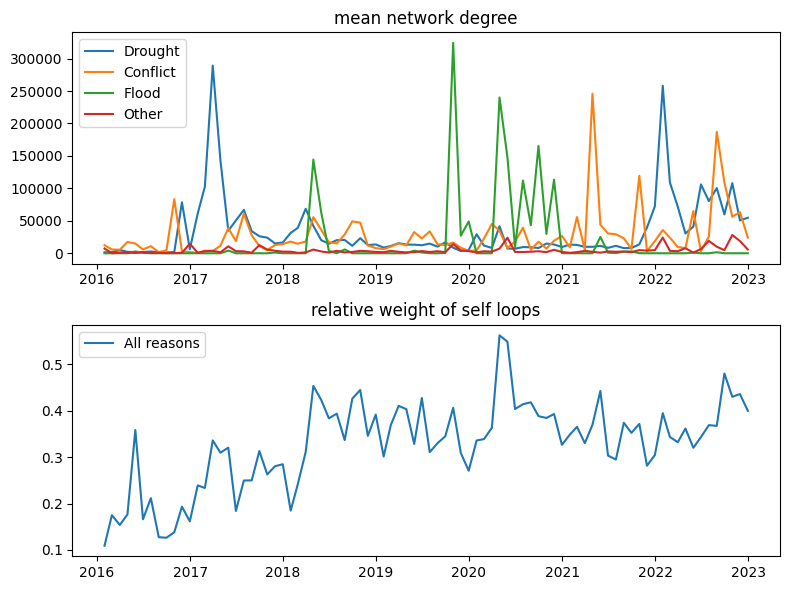

In [49]:
# plot the in degree and self weight arrays for the first file in the directory

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
palette=['r','blue']

dates = df_national_all['date'].unique()

#ax[0].plot(dates,df_national_all['in_degree'], label='Drought')
ax[0].plot(dates,df_national_d['sum_in_degree'], label='Drought')
ax[0].plot(dates,df_national_c['sum_in_degree'], label='Conflict')
ax[0].plot(dates,df_national_f['sum_in_degree'], label='Flood')
ax[0].plot(dates,df_national_o['sum_in_degree'], label='Other')
ax[0].legend(loc='upper left')
ax[0].set_title('mean network degree')
#bound yaxis
#ax[0].set_ylim(0, 5000)
ax[1].plot(dates,df_national_all['self_weight'], label='All reasons')

ax[1].set_title('relative weight of self loops')
ax[1].legend(loc='upper left')
fig.tight_layout()
#plt.savefig(r"/home/sara/Documenti/GitHub/Climate-and-conflict/pics/disp_degree_reasons.pdf")
plt.show()

## Plot national averages

In [ ]:
# initialize empty lists to store the degree and self weight arrays
df_national_list = []
df_stats_list = []

# loop over the files in the directory
for f, time in tqdm(enumerate(disp_data1['time'].unique())):
 
    df = disp_data1[disp_data1['time']==time]

    G = nx.from_pandas_edgelist(df, source='Previous (Departure) District', target='Current (Arrival) District', 
                    edge_attr=['Number of Individuals'], create_using=nx.MultiDiGraph())

    nodes = list(nx.nodes(G))
    in_degrees_dict=dict(G.in_degree(weight='Number of Individuals'))
    in_degrees = list(in_degrees_dict.values())
    out_degrees_dict=dict(G.out_degree(weight='Number of Individuals'))
    out_degrees = list(out_degrees_dict.values())
    OD = nx.adjacency_matrix(G, weight='Number of Individuals')
    OD_arr = OD.toarray()
    nan_one=np.empty(1)
    nan_one[:]=np.nan
    self_weight = [np.divide(OD_arr[i, i], np.sum(OD_arr[i]), out=nan_one, where=not(np.isnan(np.sum(OD_arr[i])) or np.sum(OD_arr[i])==0))[0] for i in range(len(OD_arr))]

    # calculate the mean and quantiles of the degree and self weight arrays
    mean_degree = np.nanmean(in_degrees)
    in_degree_quantiles = np.nanquantile(in_degrees, [0.025, 0.5, 0.975])
    out_degree_quantiles = np.nanquantile(out_degrees, [0.025, 0.5, 0.975])

    mean_self_weight = np.nanmean(self_weight)
    self_weight_quantiles = np.nanquantile(self_weight, [0.025, 0.5, 0.975])
    
    # append the degree and self weight arrays and their quantiles to the lists
    date_list=[time]*len(nodes)
    df_national=pd.DataFrame({'date':time, 'mean_degree': mean_degree, 'mean_self_weight': mean_self_weight, 'in_degree_lower': in_degree_quantiles[0], 'in_degree_median': in_degree_quantiles[1], 'in_degree_upper': in_degree_quantiles[2], 'out_degree_lower': out_degree_quantiles[0], 'out_degree_median': out_degree_quantiles[1], 'out_degree_upper': out_degree_quantiles[2], 'self_weight_lower': self_weight_quantiles[0],'self_weight_median': self_weight_quantiles[1],'self_weight_upper': self_weight_quantiles[2]}, index=[0])
    df_national_list.append(df_national)
    df_stats = pd.DataFrame({'date':date_list,'geoid': nodes, 'in_degree': in_degrees, 'out_degree': out_degrees,'self_weight': self_weight})
    df_stats_list.append(df_stats)

    df_stats = pd.concat(df_stats_list)
#df_stats['date'] = df_stats['date'].str.replace('_', '-')
df_stats['date'] = pd.to_datetime(df_stats['date'])
df_national = df_stats.groupby('date').agg({'in_degree': 'mean', 'out_degree': 'mean', 'self_weight': 'mean'})
df_national = df_national.reset_index()

#cut df_national until 2022-12-31
df_national_all = df_national[df_national['date'] <= '2022-12-31']

92it [00:04, 22.20it/s]


In [ ]:
# initialize empty lists to store the degree and self weight arrays
df_national_list = []
df_stats_list = []

disp_data2=disp_data1.copy()
disp_data2['Number of Individuals'] = np.where(disp_data2['Reason']!='Conflict/Insecurity', 0, disp_data2['Number of Individuals'])

# loop over the files in the directory
for f, time in tqdm(enumerate(disp_data2['time'].unique())):
 
    df = disp_data2[disp_data2['time']==time]

    G = nx.from_pandas_edgelist(df, source='Previous (Departure) District', target='Current (Arrival) District', 
                    edge_attr=['Number of Individuals'], create_using=nx.MultiDiGraph())

    nodes = list(nx.nodes(G))
    in_degrees_dict=dict(G.in_degree(weight='Number of Individuals'))
    in_degrees = list(in_degrees_dict.values())
    out_degrees_dict=dict(G.out_degree(weight='Number of Individuals'))
    out_degrees = list(out_degrees_dict.values())
    OD = nx.adjacency_matrix(G, weight='Number of Individuals')
    OD_arr = OD.toarray()
    nan_one=np.empty(1)
    nan_one[:]=np.nan
    self_weight = [np.divide(OD_arr[i, i], np.sum(OD_arr[i]), out=nan_one, where=not(np.isnan(np.sum(OD_arr[i])) or np.sum(OD_arr[i])==0))[0] for i in range(len(OD_arr))]

    # calculate the mean and quantiles of the degree and self weight arrays
    mean_degree = np.nanmean(in_degrees)
    in_degree_quantiles = np.nanquantile(in_degrees, [0.025, 0.5, 0.975])
    out_degree_quantiles = np.nanquantile(out_degrees, [0.025, 0.5, 0.975])

    mean_self_weight = np.nanmean(self_weight)
    self_weight_quantiles = np.nanquantile(self_weight, [0.025, 0.5, 0.975])
    
    # append the degree and self weight arrays and their quantiles to the lists
    date_list=[time]*len(nodes)
    df_national=pd.DataFrame({'date':time, 'mean_degree': mean_degree, 'mean_self_weight': mean_self_weight, 'in_degree_lower': in_degree_quantiles[0], 'in_degree_median': in_degree_quantiles[1], 'in_degree_upper': in_degree_quantiles[2], 'out_degree_lower': out_degree_quantiles[0], 'out_degree_median': out_degree_quantiles[1], 'out_degree_upper': out_degree_quantiles[2], 'self_weight_lower': self_weight_quantiles[0],'self_weight_median': self_weight_quantiles[1],'self_weight_upper': self_weight_quantiles[2]}, index=[0])
    df_national_list.append(df_national)
    df_stats = pd.DataFrame({'date':date_list,'geoid': nodes, 'in_degree': in_degrees, 'out_degree': out_degrees,'self_weight': self_weight})
    df_stats_list.append(df_stats)

    df_stats = pd.concat(df_stats_list)
#df_stats['date'] = df_stats['date'].str.replace('_', '-')
df_stats['date'] = pd.to_datetime(df_stats['date'])
df_national = df_stats.groupby('date').agg({'in_degree': 'mean', 'out_degree': 'mean', 'self_weight': 'mean'})
df_national = df_national.reset_index()

#cut df_national until 2022-12-31
df_national_c = df_national[df_national['date'] <= '2022-12-31']

92it [00:04, 20.90it/s]


In [ ]:
# initialize empty lists to store the degree and self weight arrays
df_national_list = []
df_stats_list = []

disp_data2=disp_data1.copy()
disp_data2['Number of Individuals'] = np.where(disp_data2['Reason']!='Drought related', 0, disp_data2['Number of Individuals'])

# loop over the files in the directory
for f, time in tqdm(enumerate(disp_data2['time'].unique())):
 
    df = disp_data2[disp_data2['time']==time]

    G = nx.from_pandas_edgelist(df, source='Previous (Departure) District', target='Current (Arrival) District', 
                    edge_attr=['Number of Individuals'], create_using=nx.MultiDiGraph())

    nodes = list(nx.nodes(G))
    in_degrees_dict=dict(G.in_degree(weight='Number of Individuals'))
    in_degrees = list(in_degrees_dict.values())
    out_degrees_dict=dict(G.out_degree(weight='Number of Individuals'))
    out_degrees = list(out_degrees_dict.values())
    OD = nx.adjacency_matrix(G, weight='Number of Individuals')
    OD_arr = OD.toarray()
    nan_one=np.empty(1)
    nan_one[:]=np.nan
    self_weight = [np.divide(OD_arr[i, i], np.sum(OD_arr[i]), out=nan_one, where=not(np.isnan(np.sum(OD_arr[i])) or np.sum(OD_arr[i])==0))[0] for i in range(len(OD_arr))]

    # calculate the mean and quantiles of the degree and self weight arrays
    mean_degree = np.nanmean(in_degrees)
    in_degree_quantiles = np.nanquantile(in_degrees, [0.025, 0.5, 0.975])
    out_degree_quantiles = np.nanquantile(out_degrees, [0.025, 0.5, 0.975])

    mean_self_weight = np.nanmean(self_weight)
    self_weight_quantiles = np.nanquantile(self_weight, [0.025, 0.5, 0.975])
    
    # append the degree and self weight arrays and their quantiles to the lists
    date_list=[time]*len(nodes)
    df_national=pd.DataFrame({'date':time, 'mean_degree': mean_degree, 'mean_self_weight': mean_self_weight, 'in_degree_lower': in_degree_quantiles[0], 'in_degree_median': in_degree_quantiles[1], 'in_degree_upper': in_degree_quantiles[2], 'out_degree_lower': out_degree_quantiles[0], 'out_degree_median': out_degree_quantiles[1], 'out_degree_upper': out_degree_quantiles[2], 'self_weight_lower': self_weight_quantiles[0],'self_weight_median': self_weight_quantiles[1],'self_weight_upper': self_weight_quantiles[2]}, index=[0])
    df_national_list.append(df_national)
    df_stats = pd.DataFrame({'date':date_list,'geoid': nodes, 'in_degree': in_degrees, 'out_degree': out_degrees,'self_weight': self_weight})
    df_stats_list.append(df_stats)

    df_stats = pd.concat(df_stats_list)
#df_stats['date'] = df_stats['date'].str.replace('_', '-')
df_stats['date'] = pd.to_datetime(df_stats['date'])
df_national = df_stats.groupby('date').agg({'in_degree': 'mean', 'out_degree': 'mean', 'self_weight': 'mean'})
df_national = df_national.reset_index()

#cut df_national until 2022-12-31
df_national_d = df_national[df_national['date'] <= '2022-12-31']

92it [00:04, 21.39it/s]


In [ ]:
# initialize empty lists to store the degree and self weight arrays
df_national_list = []
df_stats_list = []

disp_data2=disp_data1.copy()
disp_data2['Number of Individuals'] = np.where(disp_data2['Reason']!='Other', 0, disp_data2['Number of Individuals'])

# loop over the files in the directory
for f, time in tqdm(enumerate(disp_data2['time'].unique())):
 
    df = disp_data2[disp_data2['time']==time]

    G = nx.from_pandas_edgelist(df, source='Previous (Departure) District', target='Current (Arrival) District', 
                    edge_attr=['Number of Individuals'], create_using=nx.MultiDiGraph())

    nodes = list(nx.nodes(G))
    in_degrees_dict=dict(G.in_degree(weight='Number of Individuals'))
    in_degrees = list(in_degrees_dict.values())
    out_degrees_dict=dict(G.out_degree(weight='Number of Individuals'))
    out_degrees = list(out_degrees_dict.values())
    OD = nx.adjacency_matrix(G, weight='Number of Individuals')
    OD_arr = OD.toarray()
    nan_one=np.empty(1)
    nan_one[:]=np.nan
    self_weight = [np.divide(OD_arr[i, i], np.sum(OD_arr[i]), out=nan_one, where=not(np.isnan(np.sum(OD_arr[i])) or np.sum(OD_arr[i])==0))[0] for i in range(len(OD_arr))]

    # calculate the mean and quantiles of the degree and self weight arrays
    mean_degree = np.nanmean(in_degrees)
    in_degree_quantiles = np.nanquantile(in_degrees, [0.025, 0.5, 0.975])
    out_degree_quantiles = np.nanquantile(out_degrees, [0.025, 0.5, 0.975])

    mean_self_weight = np.nanmean(self_weight)
    self_weight_quantiles = np.nanquantile(self_weight, [0.025, 0.5, 0.975])
    
    # append the degree and self weight arrays and their quantiles to the lists
    date_list=[time]*len(nodes)
    df_national=pd.DataFrame({'date':time, 'mean_degree': mean_degree, 'mean_self_weight': mean_self_weight, 'in_degree_lower': in_degree_quantiles[0], 'in_degree_median': in_degree_quantiles[1], 'in_degree_upper': in_degree_quantiles[2], 'out_degree_lower': out_degree_quantiles[0], 'out_degree_median': out_degree_quantiles[1], 'out_degree_upper': out_degree_quantiles[2], 'self_weight_lower': self_weight_quantiles[0],'self_weight_median': self_weight_quantiles[1],'self_weight_upper': self_weight_quantiles[2]}, index=[0])
    df_national_list.append(df_national)
    df_stats = pd.DataFrame({'date':date_list,'geoid': nodes, 'in_degree': in_degrees, 'out_degree': out_degrees,'self_weight': self_weight})
    df_stats_list.append(df_stats)

    df_stats = pd.concat(df_stats_list)
#df_stats['date'] = df_stats['date'].str.replace('_', '-')
df_stats['date'] = pd.to_datetime(df_stats['date'])
df_national = df_stats.groupby('date').agg({'in_degree': 'mean', 'out_degree': 'mean', 'self_weight': 'mean'})
df_national = df_national.reset_index()

#cut df_national until 2022-12-31
df_national_o = df_national[df_national['date'] <= '2022-12-31']

92it [00:04, 21.59it/s]


In [ ]:
# initialize empty lists to store the degree and self weight arrays
df_national_list = []
df_stats_list = []

disp_data2=disp_data1.copy()
disp_data2['Number of Individuals'] = np.where(disp_data2['Reason']!='Flood', 0, disp_data2['Number of Individuals'])

# loop over the files in the directory
for f, time in tqdm(enumerate(disp_data2['time'].unique())):
 
    df = disp_data2[disp_data2['time']==time]

    G = nx.from_pandas_edgelist(df, source='Previous (Departure) District', target='Current (Arrival) District', 
                    edge_attr=['Number of Individuals'], create_using=nx.MultiDiGraph())

    nodes = list(nx.nodes(G))
    in_degrees_dict=dict(G.in_degree(weight='Number of Individuals'))
    in_degrees = list(in_degrees_dict.values())
    out_degrees_dict=dict(G.out_degree(weight='Number of Individuals'))
    out_degrees = list(out_degrees_dict.values())
    OD = nx.adjacency_matrix(G, weight='Number of Individuals')
    OD_arr = OD.toarray()
    nan_one=np.empty(1)
    nan_one[:]=np.nan
    self_weight = [np.divide(OD_arr[i, i], np.sum(OD_arr[i]), out=nan_one, where=not(np.isnan(np.sum(OD_arr[i])) or np.sum(OD_arr[i])==0))[0] for i in range(len(OD_arr))]

    # calculate the mean and quantiles of the degree and self weight arrays
    mean_degree = np.nanmean(in_degrees)
    in_degree_quantiles = np.nanquantile(in_degrees, [0.025, 0.5, 0.975])
    out_degree_quantiles = np.nanquantile(out_degrees, [0.025, 0.5, 0.975])

    mean_self_weight = np.nanmean(self_weight)
    self_weight_quantiles = np.nanquantile(self_weight, [0.025, 0.5, 0.975])
    
    # append the degree and self weight arrays and their quantiles to the lists
    date_list=[time]*len(nodes)
    df_national=pd.DataFrame({'date':time, 'mean_degree': mean_degree, 'mean_self_weight': mean_self_weight, 'in_degree_lower': in_degree_quantiles[0], 'in_degree_median': in_degree_quantiles[1], 'in_degree_upper': in_degree_quantiles[2], 'out_degree_lower': out_degree_quantiles[0], 'out_degree_median': out_degree_quantiles[1], 'out_degree_upper': out_degree_quantiles[2], 'self_weight_lower': self_weight_quantiles[0],'self_weight_median': self_weight_quantiles[1],'self_weight_upper': self_weight_quantiles[2]}, index=[0])
    df_national_list.append(df_national)
    df_stats = pd.DataFrame({'date':date_list,'geoid': nodes, 'in_degree': in_degrees, 'out_degree': out_degrees,'self_weight': self_weight})
    df_stats_list.append(df_stats)

    df_stats = pd.concat(df_stats_list)
#df_stats['date'] = df_stats['date'].str.replace('_', '-')
df_stats['date'] = pd.to_datetime(df_stats['date'])
df_national = df_stats.groupby('date').agg({'in_degree': 'mean', 'out_degree': 'mean', 'self_weight': 'mean'})
df_national = df_national.reset_index()

#cut df_national until 2022-12-31
df_national_f = df_national[df_national['date'] <= '2022-12-31']

0it [00:00, ?it/s]/tmp/ipykernel_5783/2743451392.py:32: RuntimeWarning: Mean of empty slice
  mean_self_weight = np.nanmean(self_weight)
/home/sara/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
92it [00:04, 20.26it/s]


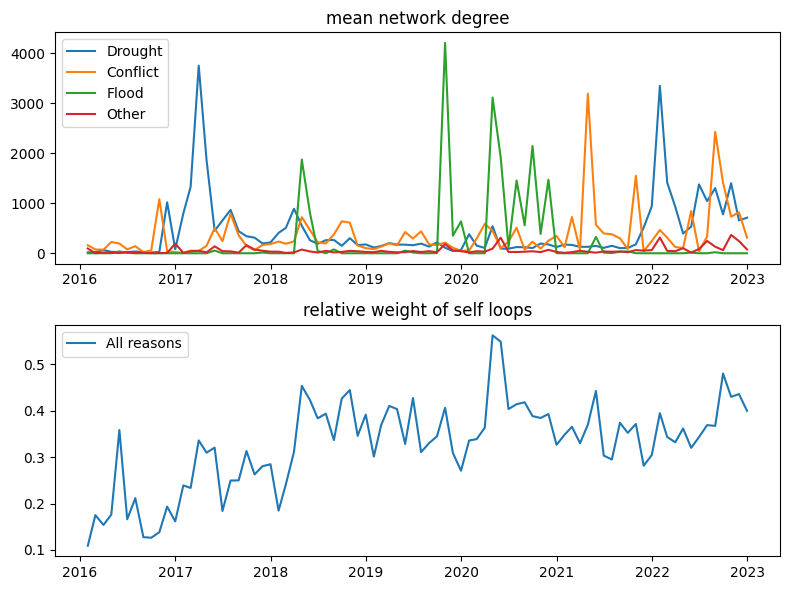

In [42]:
# plot the in degree and self weight arrays for the first file in the directory

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
palette=['r','blue']

dates = df_national_all['date'].unique()

#ax[0].plot(dates,df_national_all['in_degree'], label='Drought')
ax[0].plot(dates,df_national_d['in_degree'], label='Drought')
ax[0].plot(dates,df_national_c['in_degree'], label='Conflict')
ax[0].plot(dates,df_national_f['in_degree'], label='Flood')
ax[0].plot(dates,df_national_o['in_degree'], label='Other')
ax[0].legend(loc='upper left')
ax[0].set_title('mean network degree')
#bound yaxis
#ax[0].set_ylim(0, 5000)
ax[1].plot(dates,df_national_all['self_weight'], label='All reasons')

ax[1].set_title('relative weight of self loops')
ax[1].legend(loc='upper left')
fig.tight_layout()
#plt.savefig(r"/home/sara/Documenti/GitHub/Climate-and-conflict/pics/disp_degree_reasons.pdf")
plt.show()

## Plot by state

In [11]:
#aggregate by state
cont = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp")

In [12]:
reg_state = disp_data[['Previous (Departure) District','Previous (Departure) Region']]
#remove duplicates from reg_state
reg_state = reg_state.drop_duplicates('Previous (Departure) District', keep='first')

In [13]:
df_merged_district = pd.merge(df_stats, reg_state, left_on=['geoid'], right_on=['Previous (Departure) District'], how='left')
df_agg_d = df_merged_district.groupby(['geoid', 'date']).agg({'in_degree': 'mean', 'out_degree': 'mean', 'self_weight': 'mean'})
df_agg_d.reset_index(inplace=True)
df_agg_d['date']=pd.to_datetime(df_agg_d['date'])

In [14]:
df_merged_region = pd.merge(df_stats, reg_state, left_on=['geoid'], right_on=['Previous (Departure) District'], how='left')
df_agg_r = df_merged_region.groupby(['Previous (Departure) Region', 'date']).agg({'in_degree': 'mean', 'out_degree': 'mean', 'self_weight': 'mean'})
df_agg_r.reset_index(inplace=True)
df_agg_r['date']=pd.to_datetime(df_agg_r['date'])

In [15]:
df_agg_r['internal mobility'] = df_agg_r['self_weight']*df_agg_r['out_degree']
df_agg_r['external mobility out'] = df_agg_r['out_degree'] - df_agg_r['internal mobility']
df_agg_r['external mobility in'] = df_agg_r['in_degree'] - df_agg_r['internal mobility']
df_agg_r['external mobility total'] = df_agg_r['external mobility out'] + df_agg_r['external mobility in']

In [16]:
#subset to take only 2022
df_agg_r_2022 = df_agg_r[df_agg_r['date'].dt.year == 2022]

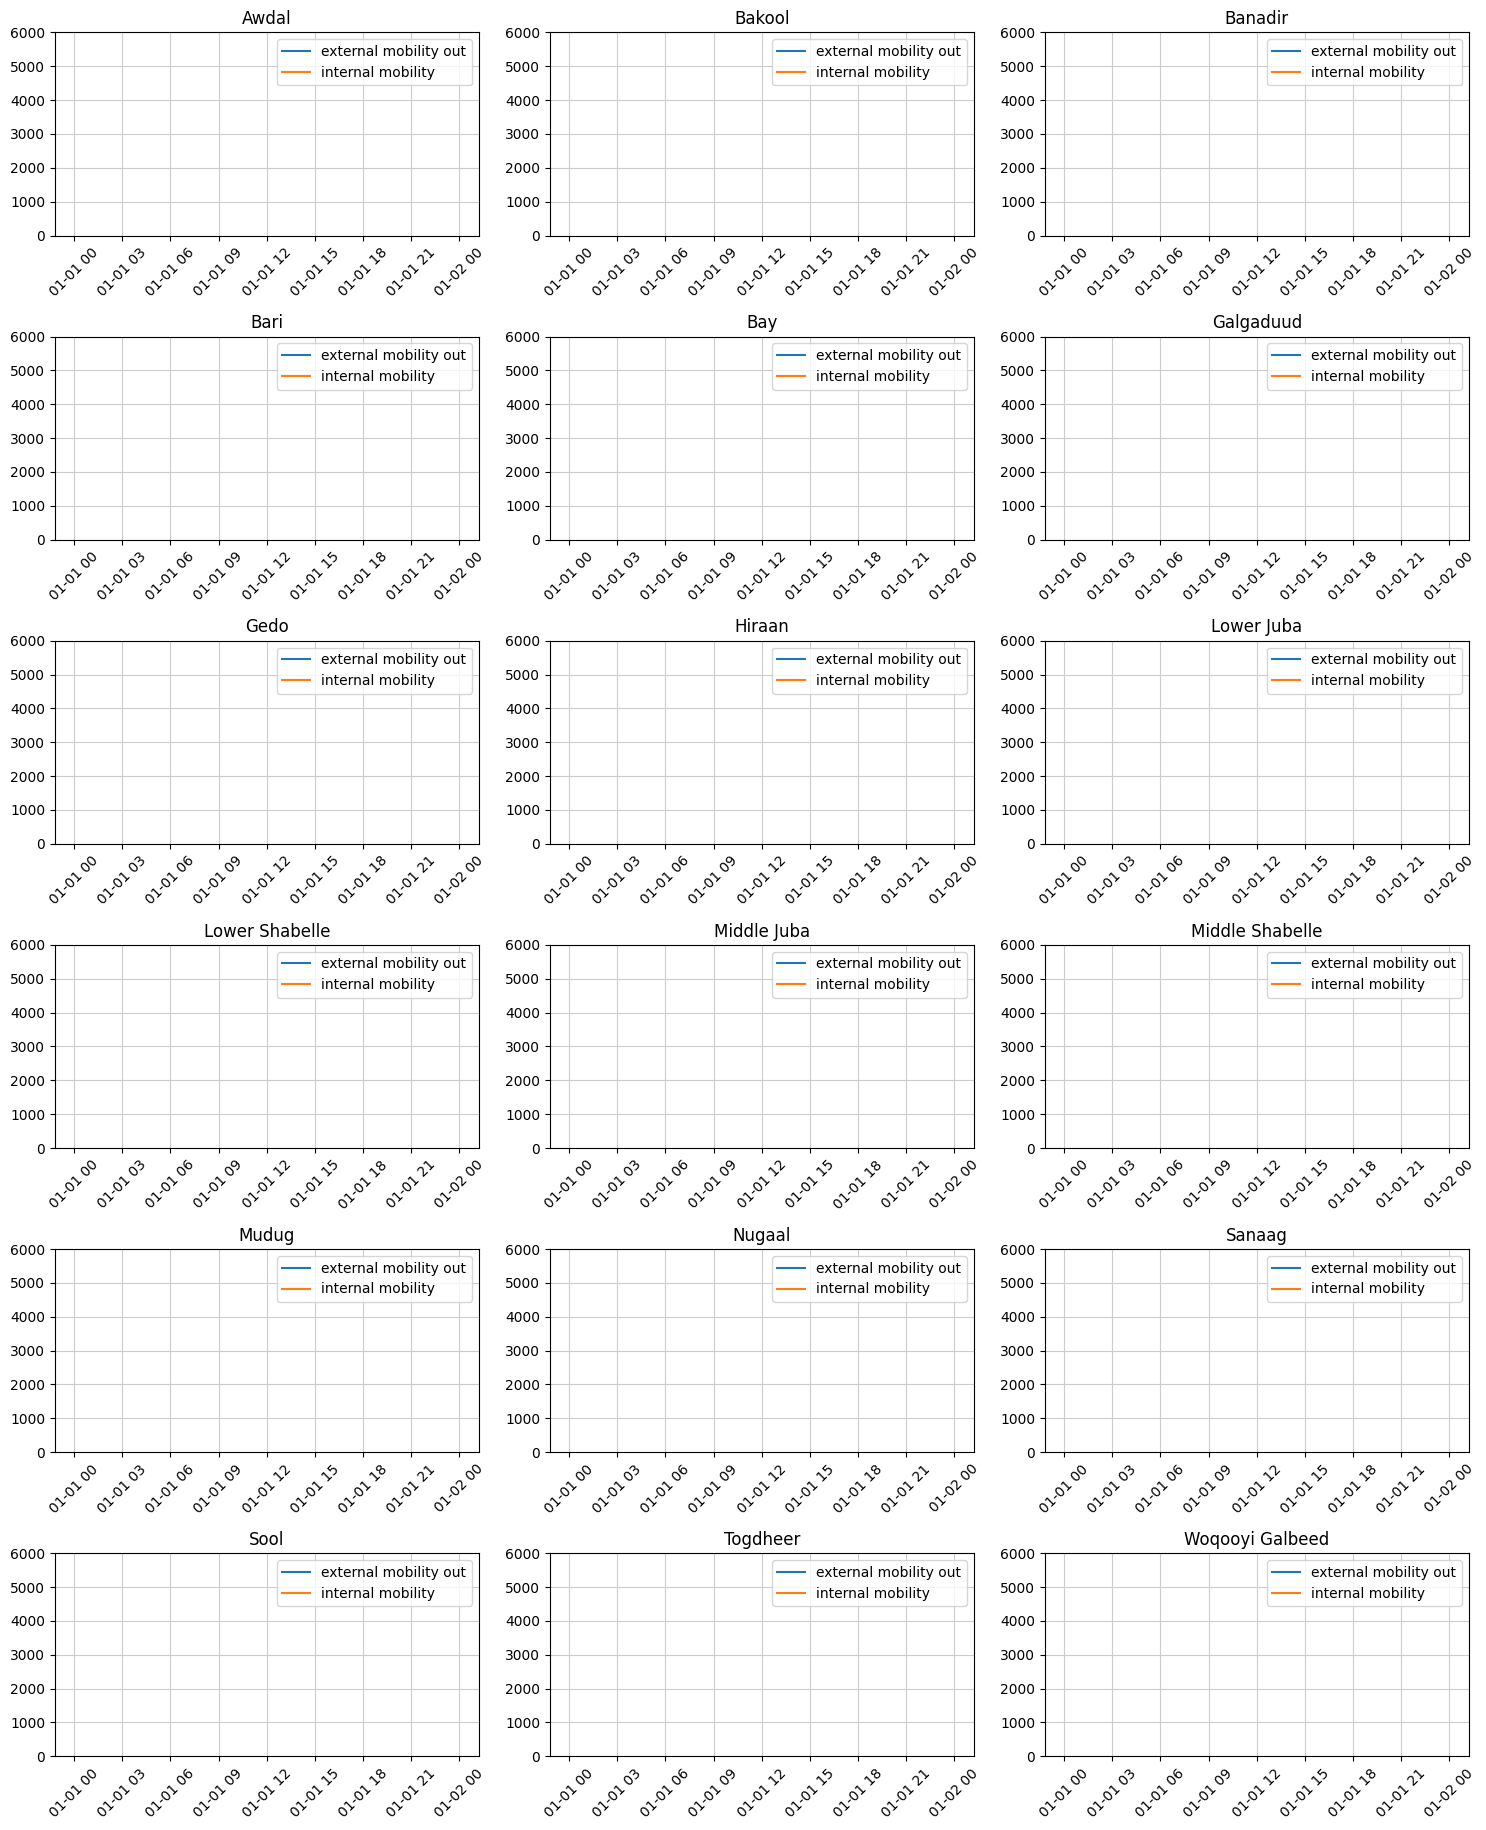

In [17]:
# create a figure with subplots
fig, axes = plt.subplots(6, 3, figsize=(15, 20))
ax = axes.flatten()
states = df_agg_r_2022['Previous (Departure) Region'].unique()
# iterate over the states
for i, state in zip(range(len(states)), states):

    df_agg_state = df_agg_r_2022[df_agg_r_2022['Previous (Departure) Region']==state]
    # plot value of stringency index for each date
    ax[i].plot(df_agg_state['date'], df_agg_state['external mobility out'], label='external mobility out')
    ax[i].plot(df_agg_state['date'], df_agg_state['internal mobility'], label='internal mobility')  
    #ax[i].twinx().plot(df_agg_state['date'], df_agg_state['internal mobility'], label='internal mobility', color='red')

    ax[i].tick_params(axis='x', rotation=45)

    # add a grid
    ax[i].grid(True, color = '0.8', which='major')
    ax[i].grid(True, color = '0.8', alpha = 0.5, which='minor', linestyle='--')

    ax[i].legend()
    # set state name as title
    ax[i].set_title(state)
    ax[i].set_ylim([0, 6000])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [18]:
# start_date=pd.to_datetime('2020-01-01')
# end_date=pd.to_datetime('2021-04-28')
# df_agg1_cut=df_agg1[(df_agg1['date']>=start_date) & (df_agg1['date']<=end_date)]
# df_agg1_cut=df_agg1_cut.sort_values(by='date')
# df_agg1_cut=df_agg1_cut.reset_index(drop=True)

## Plot in and out degree for each subregion

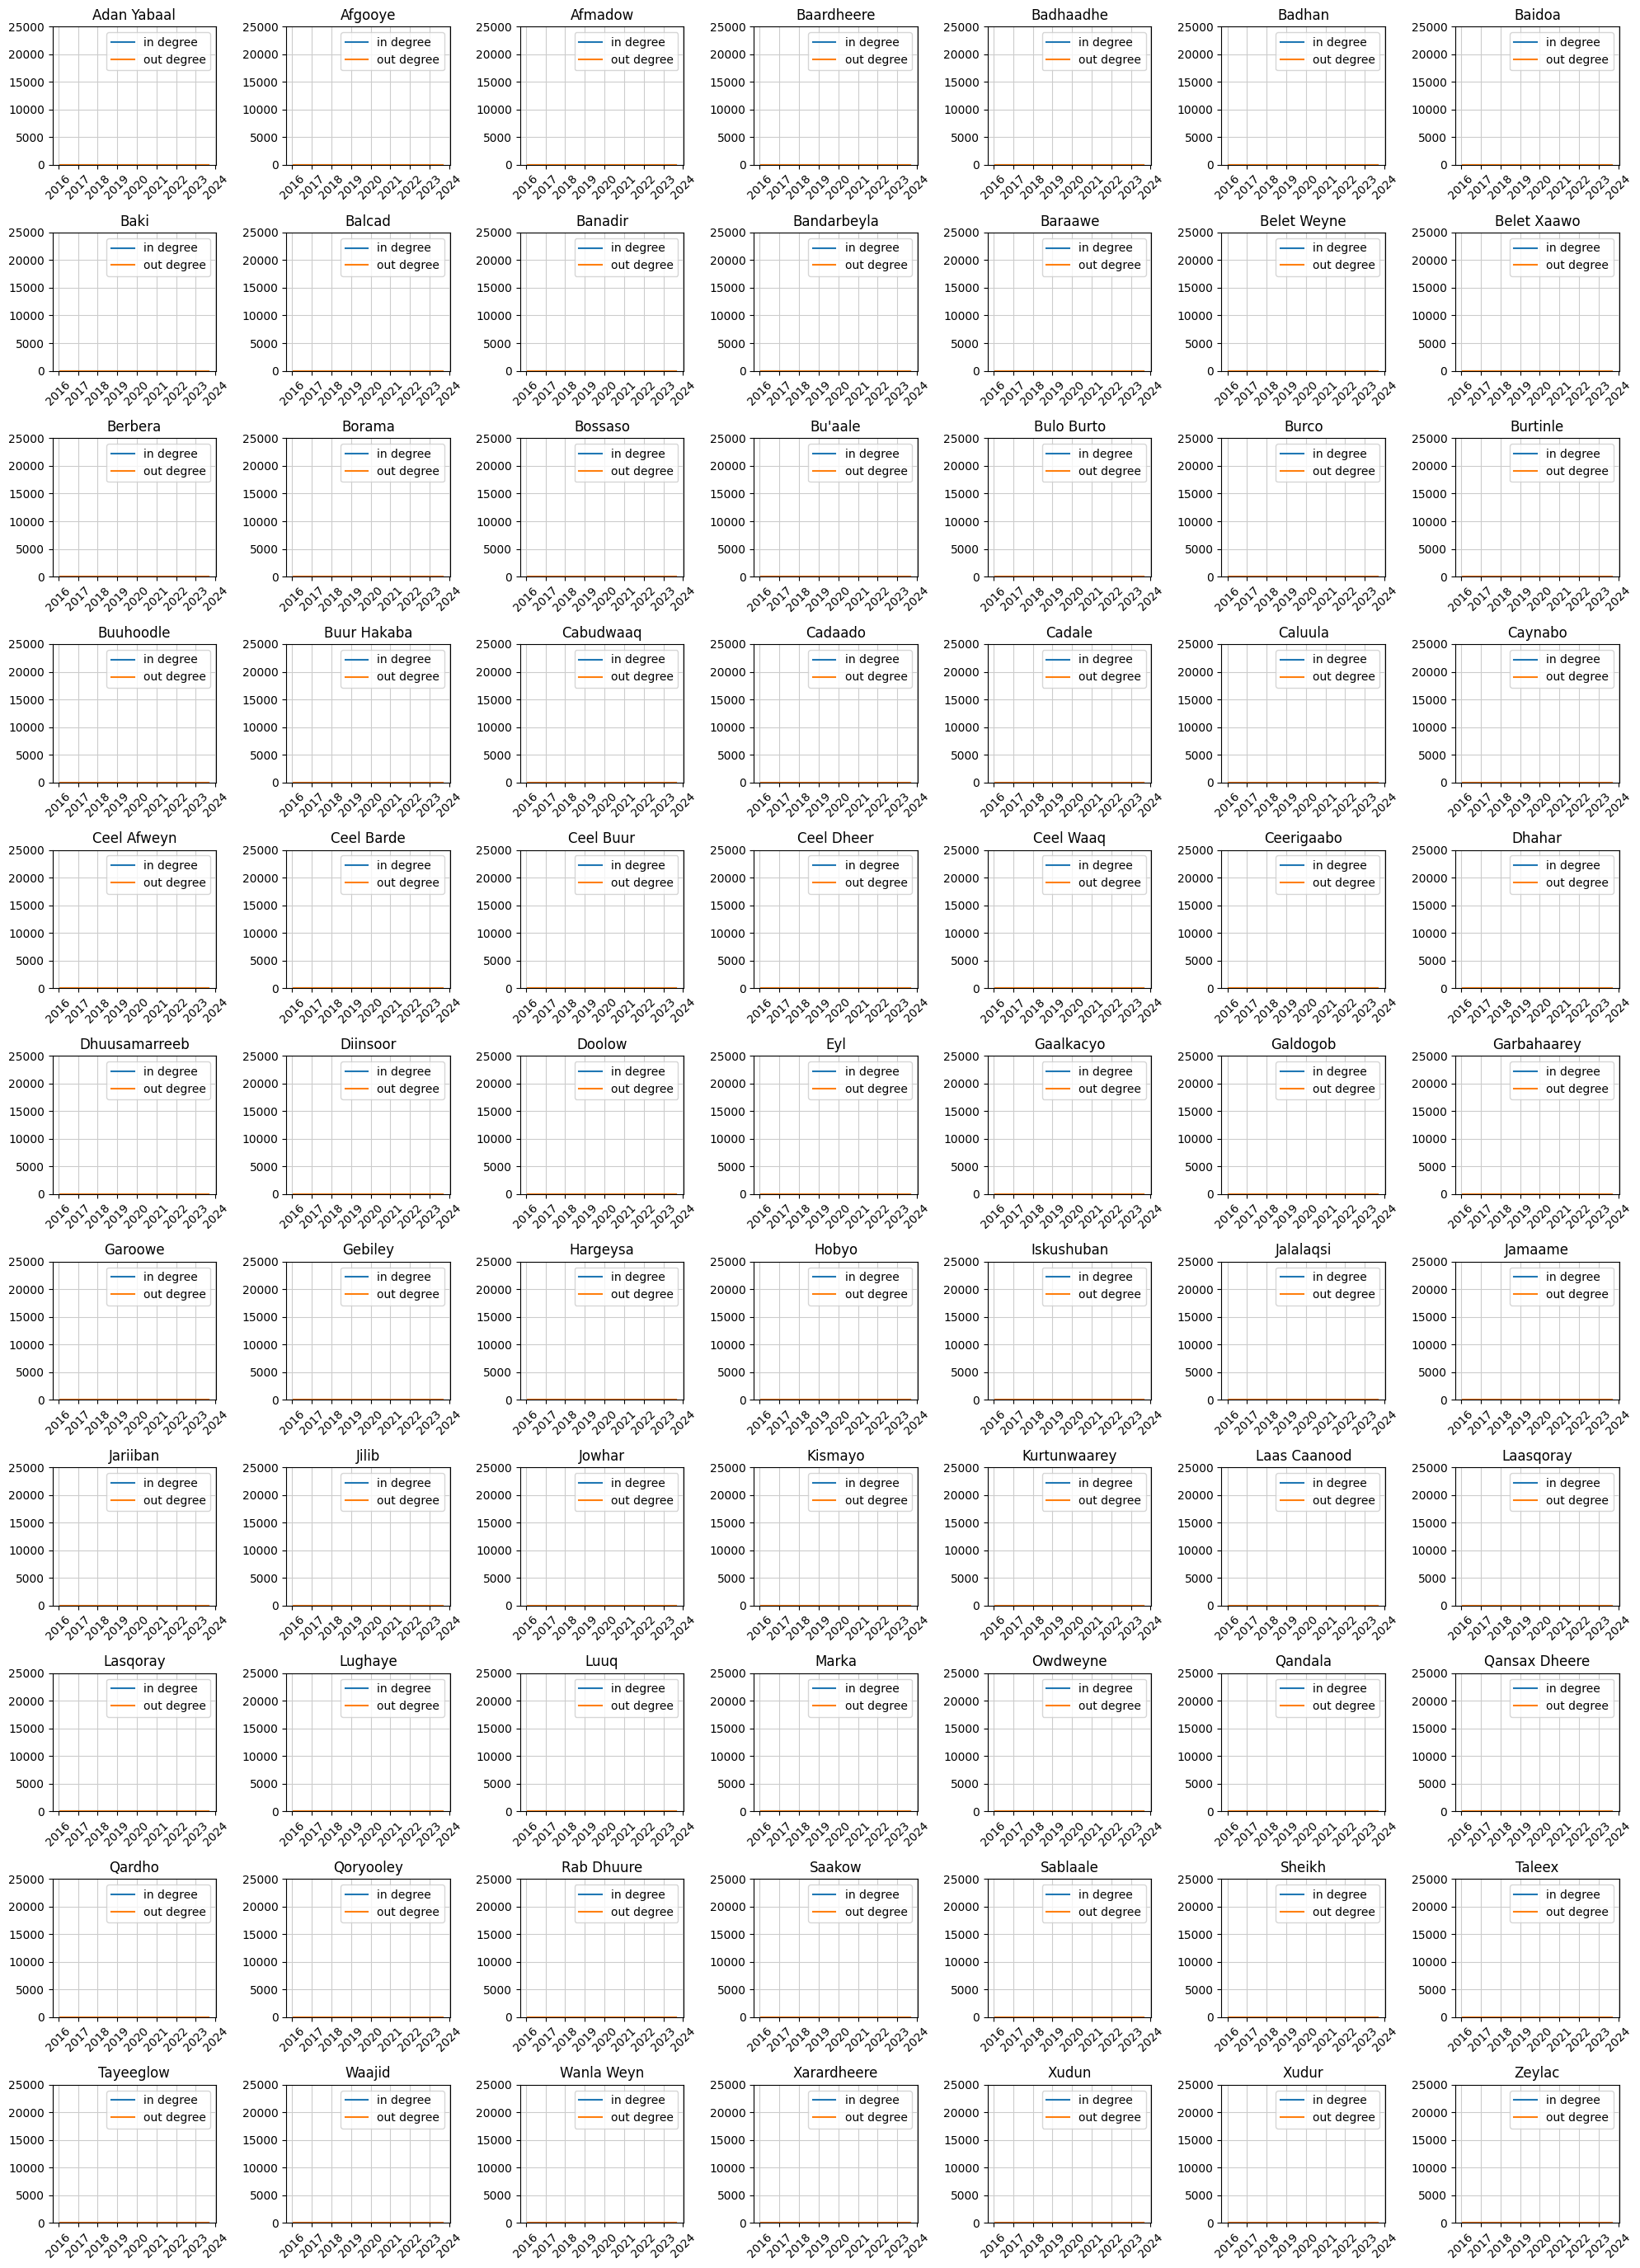

In [19]:
# create a figure with subplots
fig, axes = plt.subplots(11, 7, figsize=(20, 30))
ax = axes.flatten()
states = df_agg_d['geoid'].unique()
# iterate over the states
for i, state in zip(range(len(states)), states):

    df_agg_state = df_agg_d[df_agg_d['geoid']==state]
    # plot value of stringency index for each date
    ax[i].plot(df_agg_state['date'], df_agg_state['in_degree'], label='in degree')
    ax[i].plot(df_agg_state['date'], df_agg_state['out_degree'], label='out degree')  
    
    ax[i].tick_params(axis='x', rotation=45)

    # add a grid
    ax[i].grid(True, color = '0.8', which='major')
    ax[i].grid(True, color = '0.8', alpha = 0.5, which='minor', linestyle='--')

    ax[i].legend()
    # set state name as title
    ax[i].set_title(state)
    ax[i].set_ylim([0, 25000])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig('subregions.pdf')
plt.show()

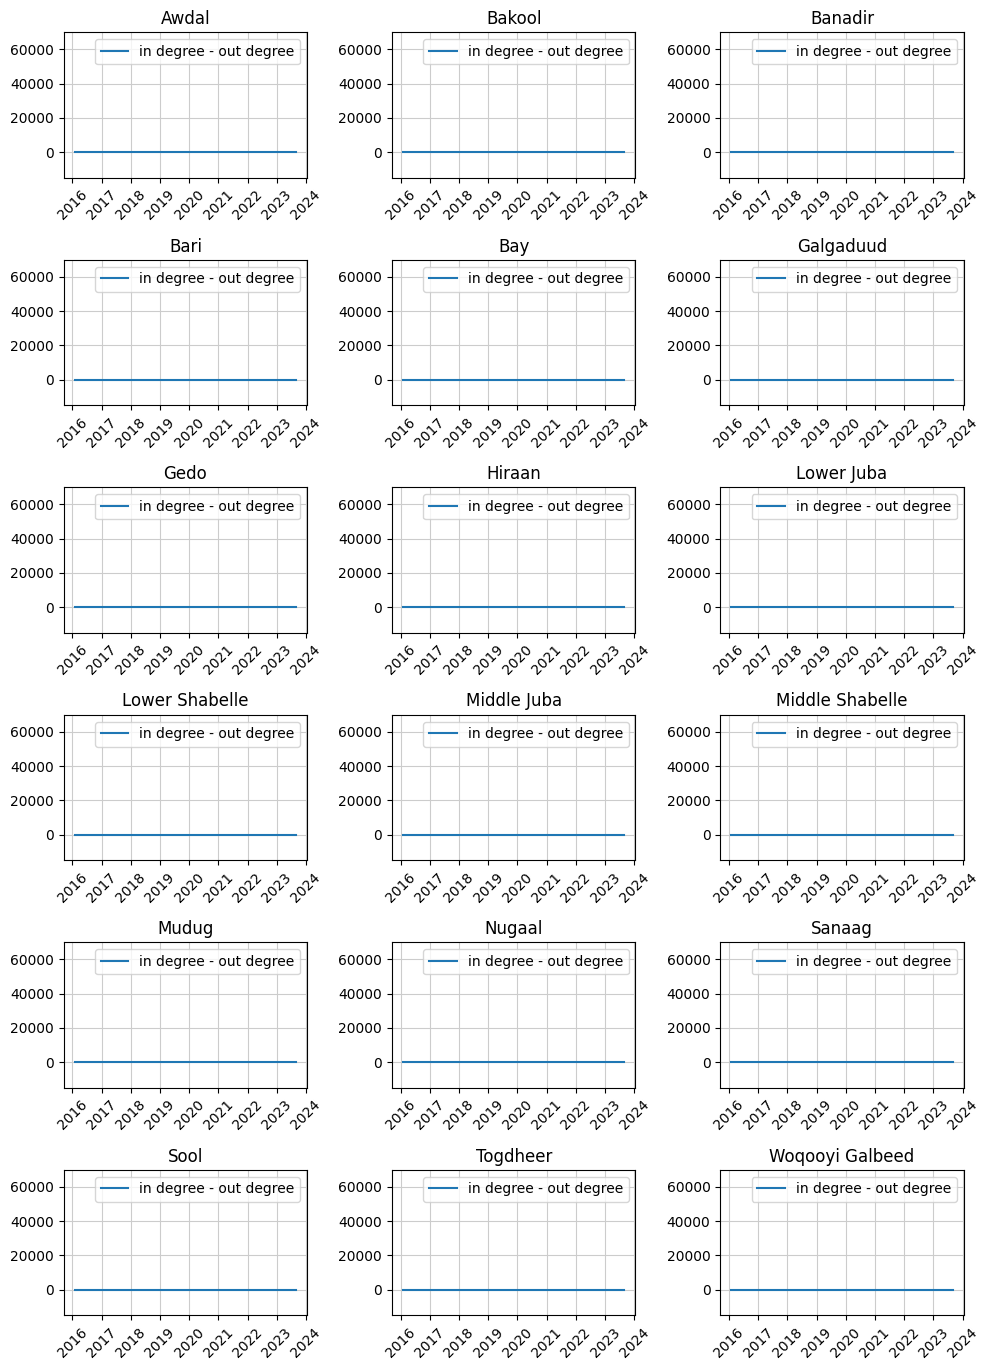

In [20]:
# create a figure with subplots
fig, axes = plt.subplots(6, 3, figsize=(10, 15))
ax = axes.flatten()
states = df_agg_r['Previous (Departure) Region'].unique()
# iterate over the states
for i, state in zip(range(len(states)), states):

    df_agg_state = df_agg_r[df_agg_r['Previous (Departure) Region']==state]
    # plot value of stringency index for each date
    ax[i].plot(df_agg_state['date'], df_agg_state['in_degree'] - df_agg_state['out_degree'], label='in degree - out degree')  
    ax[i].tick_params(axis='x', rotation=45)
    # add a grid
    ax[i].grid(True, color = '0.8', which='major')
    ax[i].legend()
    # set state name as title
    ax[i].set_title(state)
    ax[i].set_ylim([-15000, 70000])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig('in-out_degree.pdf')
plt.show()

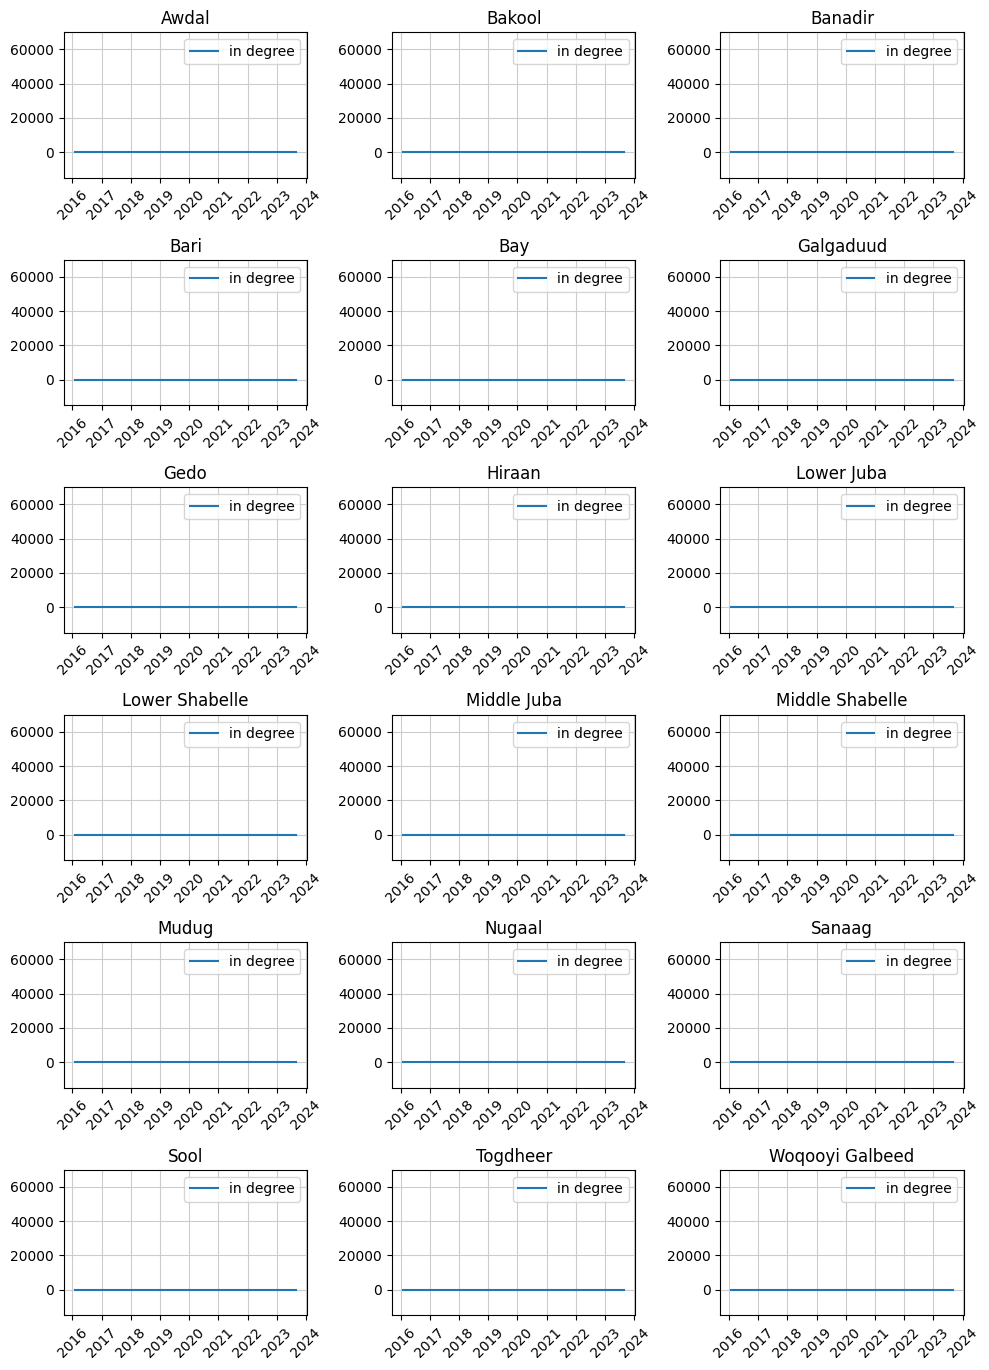

In [21]:
# create a figure with subplots
fig, axes = plt.subplots(6, 3, figsize=(10, 15))
ax = axes.flatten()
states = df_agg_r['Previous (Departure) Region'].unique()
# iterate over the states
for i, state in zip(range(len(states)), states):

    df_agg_state = df_agg_r[df_agg_r['Previous (Departure) Region']==state]
    # plot value of stringency index for each date
    ax[i].plot(df_agg_state['date'], df_agg_state['in_degree'], label='in degree')  
    ax[i].tick_params(axis='x', rotation=45)
    # add a grid
    ax[i].grid(True, color = '0.8', which='major')
    ax[i].legend()
    # set state name as title
    ax[i].set_title(state)
    ax[i].set_ylim([-15000, 70000])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig('in-out_degree.pdf')
plt.show()

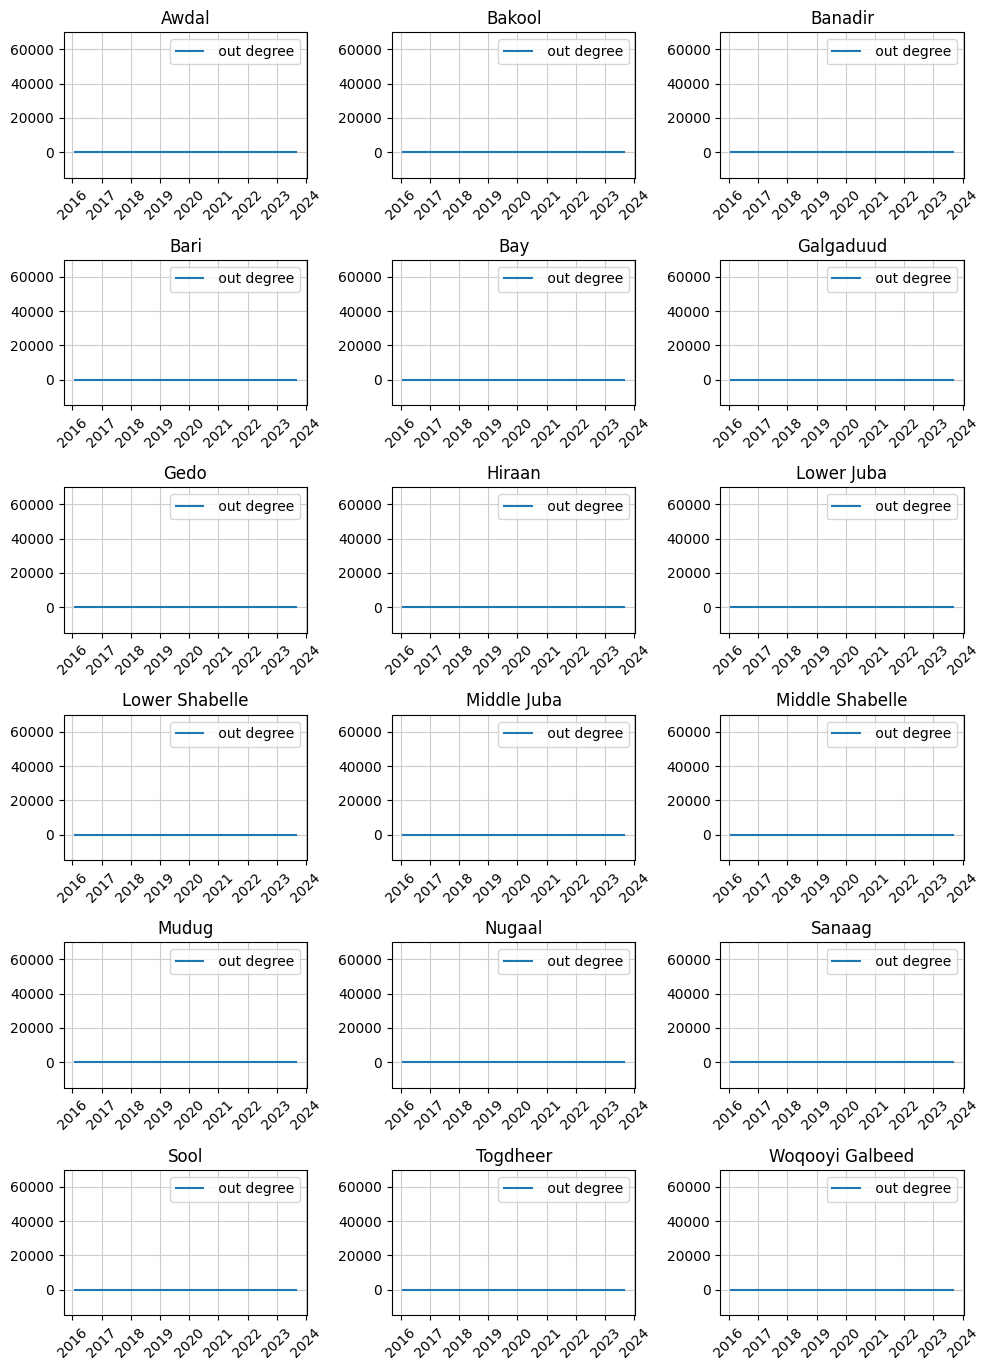

In [22]:
# create a figure with subplots
fig, axes = plt.subplots(6, 3, figsize=(10, 15))
ax = axes.flatten()
states = df_agg_r['Previous (Departure) Region'].unique()
# iterate over the states
for i, state in zip(range(len(states)), states):

    df_agg_state = df_agg_r[df_agg_r['Previous (Departure) Region']==state]
    # plot value of stringency index for each date
    ax[i].plot(df_agg_state['date'],  df_agg_state['out_degree'], label=' out degree')  
    ax[i].tick_params(axis='x', rotation=45)
    # add a grid
    ax[i].grid(True, color = '0.8', which='major')
    ax[i].legend()
    # set state name as title
    ax[i].set_title(state)
    ax[i].set_ylim([-15000, 70000])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig('in-out_degree.pdf')
plt.show()

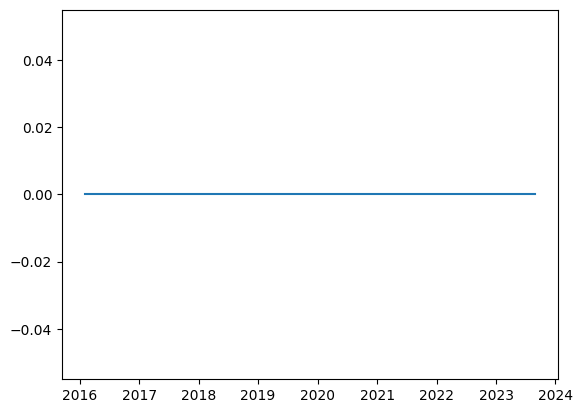

In [23]:
#sum out degree of each subregion and plot it
df_agg_r_sum = df_agg_r.groupby(['date']).agg({'out_degree': 'sum'})
df_agg_r_sum['in'] = df_agg_r.groupby(['date']).agg({'in_degree': 'sum'})

df_agg_r_sum.reset_index(inplace=True)
df_agg_r_sum['date']=pd.to_datetime(df_agg_r_sum['date'])
plt.plot(df_agg_r_sum['date'], df_agg_r_sum['out_degree'])

In [24]:
df_agg_r_sum['diff'] = df_agg_r_sum['in'] - df_agg_r_sum['out_degree']

In [25]:
df_agg_r_sum

,date,out_degree,in,diff
0,2016-01-31,0.0,0.0,0.0
1,2016-02-29,0.0,0.0,0.0
2,2016-03-31,0.0,0.0,0.0
3,2016-04-30,0.0,0.0,0.0
4,2016-05-31,0.0,0.0,0.0
...,...,...,...,...
87,2023-04-30,0.0,0.0,0.0
88,2023-05-31,0.0,0.0,0.0
89,2023-06-30,0.0,0.0,0.0
90,2023-07-31,0.0,0.0,0.0


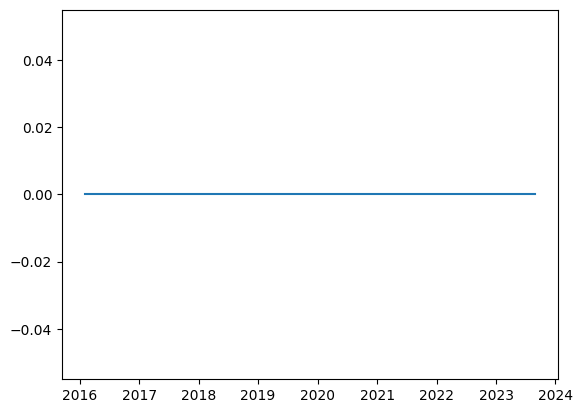

In [26]:
#plot diff out and in 
plt.plot(df_agg_r_sum['date'], df_agg_r_sum['out_degree'])
plt.show()